In [2]:
"""
Here, we are going to work on implementing Equations 14 and 15 from the simulation paper 
"Simulating low-frequency wind fluctuations" (roughly) -- Mann and Syed 2024.
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.special as special

from typing import Optional

import sys
sys.path.append("..")

import low_freq_prototype as lfp

In [ ]:
class LowFreq2D_Fourier:
    """
    This class is used to generate the Fourier coefficients for the low-frequency
    2d turbulence field. See 
    """

## Equation 14

The following is the "full version" of the integral used to solve for the
Fourier coefficients.


$$ C_ij^*({\bf k}) C_ij({\bf k}) = \int \phi_{ij}({\bf k'}) \prod_{l=1}^2
\operatorname{sinc}^2\left( \frac{(k_l - k_{l'} L_l)}{2} \right) \rm{d}\mathbf{k'}$$


# Equation 15

In the case that both $L_1, L_2 \gg L_{2D}$, we will use

$$ C_{ij}^*({\bf k}) C_{ij}({\bf k}) = \frac{4\pi^2}{L_1 L_2} \phi_{ij}({\bf k})$$


# Equation 16


"Usually, $L_{2} \ll L_{2D}$ when simulating wind fields for single wind turbine load calculations."

In this case, we use

$$ 
C_{ij}^*({\bf k}) C_{ij}({\bf k}) = \frac{2\pi}{L_1}
\int \phi_{ij}(k_1, k_2') \operatorname{sinc}^2\left(
    \frac{(k_2 - k_2') L_2}{2}
\right) ~ \rm{d}k_2'
$$

In [1]:
import Fij_numerical_integrator as fij

In [21]:
import warnings

# import numpy as np
# import scipy.integrate as integrate

# # import scipy.special as special


def _calculate_kappa(k1: float, k2: float, psi: float) -> float:
    """
    Calculate the "augmented wavenumber" kappa
    """

    return np.sqrt(2 * ((k1 * np.cos(psi))**2 + (k2 * np.sin(psi))**2))


def _E_kappa(kappa: float, L2D: float, c: float) -> float:
    """
    Calculates the energy spectrum in terms of kappa = sqrt(2(k1^2cos^2psi + k2^2sin^2psi))
    """
    numerator = c * (kappa**3)
    denominator = (L2D**(-2) + kappa**2)**(7/3)

    return numerator / denominator

def _E_kappa_attenuated(kappa: float, L2D: float, z_i: float, c: float) -> float:
    """
    Attenuated energy spectrum in terms of kappa
    """

    return _E_kappa(kappa, L2D, c) / (1 + (kappa * z_i)**2)


def _spectral_tensor_common(kappa: float, k: float, L2D: float, z_i: float, c: float) -> float:
    """
    Common spectral tensor calculations
    """

    energy = _E_kappa_attenuated(kappa, L2D, z_i, c)

    denom = np.pi * kappa

    return energy / denom


def _spectral_tensor_11(k1: float, k2: float, psi: float, L2D: float, z_i: float, c: float) -> float:
    """
    Simulated spectral tensor i = j = 1 component

    Note that all that varies between this and the 22 method is the "parenthetical"
    """
    kappa = _calculate_kappa(k1, k2, psi)
    k = np.sqrt(k1**2 + k2**2)
    
    leading_factor = _spectral_tensor_common(kappa, k, L2D, z_i, c)

    parenthetical = 1 - (k1/k)**2

    return leading_factor * parenthetical


######################################################################################################################
# "Public" integrator methods

def eq6_numerical_F11_2D(k1: float, psi: float, L2D: float, z_i: float, c: float) -> float:
    """
    By numerical integration, provides an "analytical" solution for F_11 2-dimensional spectrum
    """
    res, err = integrate.quad(
        lambda k2: _spectral_tensor_11(k1, k2, psi, L2D, z_i, c),
        -np.inf, np.inf
    )

    return res, err


Average error with attenuation: 0.0000000016
Max error with attenuation: 0.0000000016
L2 norm with attenuation: 0.0000000016


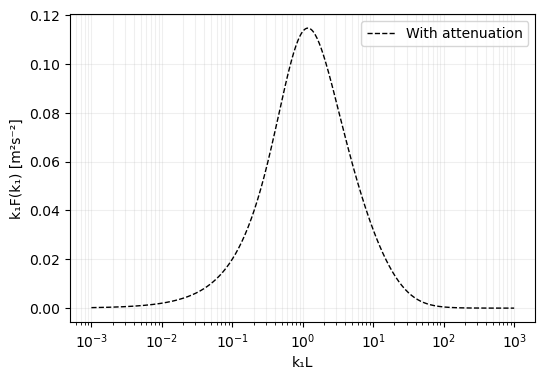

In [3]:
"""
This cell aims to recreate Figure 1 in the theory paper.
"""

plt.clf(); plt.close('all');

L2D = 20_000 # km
z_i = 500 # m
psi = np.deg2rad(43)
c = 5e-8
k1L = np.logspace(-3, 3, 400)

atten_err_list = []
numerical_F11_attenuated = []

for k1 in k1L:
    atten_res, atten_err = fij.eq6_numerical_F11_2D(k1 / L2D, psi, L2D, z_i, c)

    atten_err_list.append(atten_err)
    numerical_F11_attenuated.append(k1 * atten_res)

############################################
# Print some basic stats for the integration errors

print(f"Average error with attenuation: {np.mean(atten_err):.10f}")
print(f"Max error with attenuation: {np.max(atten_err):.10f}")
print(f"L2 norm with attenuation: {np.linalg.norm(atten_err):.10f}")

############################################
# Plot

plt.figure(figsize=(6, 4))

plt.plot(k1L, numerical_F11_attenuated, "--", color="black", label="With attenuation", linewidth=1)
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("k₁F(k₁) [m²s⁻²]")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()